# True Parameters (0.2, 3)

## Variance

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\rikhi\AppData\Local\Temp\ipykernel_28516\2624002935.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vario_ = torch.tensor(vario_) + variogram(obs_z[k], sims, dist_mat, 1)
100%|██████████| 100/100 [00:23<00:00,  4.21it/s]


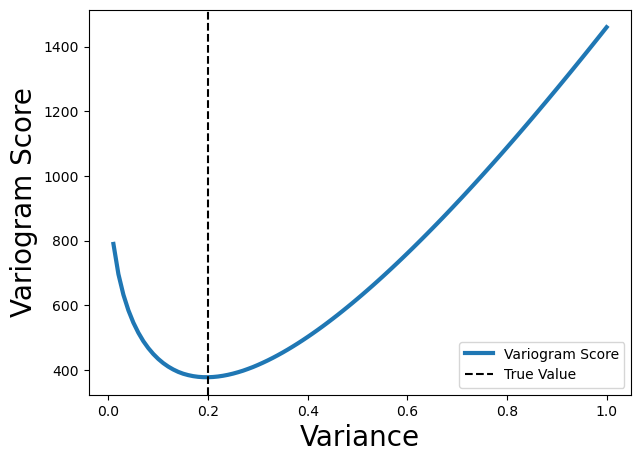

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal
from tqdm import tqdm

def variogram(obs, sims, dist_mat, p):
    '''
    Variogram score from eq 10 in Pacchiardi paper [2024 Probabilistic Forecasting with Generative Networks
    via Scoring Rule Minimization] in JMLR.

    SR = sum_ij w_ij * (|y_i - y_j|^p - |Y_k,i - Y_k,j|^p)^2
    '''
    n = obs.size(0)
    m = sims.size(0)
    w_ij = torch.nan_to_num(1 / dist_mat, nan=0, posinf=0, neginf=0)
    diff_y_y = torch.abs(obs.unsqueeze(1) - obs) ** p
    diff_Y_Y = torch.abs(sims.unsqueeze(2) - sims.unsqueeze(1)).pow(p).mean(dim=0)

    SR = w_ij * (diff_y_y - diff_Y_Y) ** 2
    return SR.sum().item()

def pairwise_distance(x1, x2):
    return ((x1.unsqueeze(1) - x2.unsqueeze(0)) ** 2).sum(-1)

def RBF(variance, length_scale):
    def rbf_kernel(x1, x2):
        dist = pairwise_distance(x1, x2)
        covariance_matrix = variance*torch.exp(-0.5 * dist / length_scale ** 2)
        # Ensure positive definiteness using Cholesky decomposition
        try:
            L = torch.cholesky(covariance_matrix, upper=False)
        except RuntimeError:
            min_eig = torch.min(torch.linalg.eigvalsh(covariance_matrix))
            covariance_matrix += torch.eye(covariance_matrix.shape[0]) * (-min_eig + 1e-6)
        
        return covariance_matrix
    return rbf_kernel


locs = torch.meshgrid(torch.tensor([0,1,2,3,4]), torch.tensor([0,1,2,3,4]))
locs = torch.stack((locs[0].flatten(), locs[1].flatten())).t().float()

# Define the RBF kernel using the RBF function
length_scale = 3
variance = 0.2
rbf_kernel = RBF(variance, length_scale)

# Compute the true covariance matrix
true_cov = rbf_kernel(locs, locs)

mvn = MultivariateNormal(torch.zeros(25), covariance_matrix=true_cov.float())
obs_z = mvn.sample((100,))

# Variogram
SR_V = []
mean = torch.zeros(25)
for i in tqdm(torch.linspace(0.01, 1, 100)):
    torch.manual_seed(42)  # You can use any integer value as the seed
    cov_ = RBF(i, length_scale)(locs, locs)
    vario_ = 0
    for k in range(len(obs_z)):
        multi = MultivariateNormal(torch.zeros(25), covariance_matrix=cov_.float())
        sims = multi.sample((100,))
        vario_ = torch.tensor(vario_) + variogram(obs_z[k], sims, dist_mat, 1)
    SR_V.append(vario_.item())


plt.figure(figsize=(7, 5))
plt.plot(torch.linspace(0.01, 1, 100), SR_V , label='Variogram Score', linewidth=3)
plt.axvline(x=0.2, color='black', linestyle='--', label='True Value')
plt.legend()


plt.xlabel('Variance', fontsize=20)
plt.ylabel('Variogram Score', fontsize=20)


plt.show()



## Length Scale

C:\Users\rikhi\anaconda3\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
C:\Users\rikhi\AppData\Local\Temp\ipykernel_28516\2364365559.py:32: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\BatchLinearAlgebra.cpp:1703.)
  L = torch.cholesky(covariance_matrix, upper=False)
  0%|          | 0/100 [00:00<?,

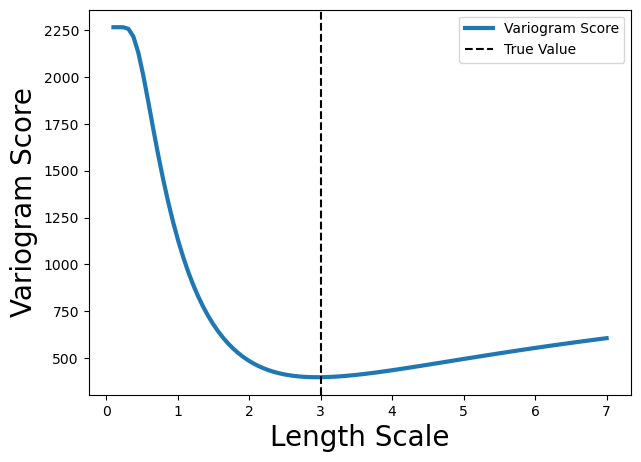

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal
from tqdm import tqdm

def variogram(obs, sims, dist_mat, p):
    '''
    Variogram score from eq 10 in Pacchiardi paper [2024 Probabilistic Forecasting with Generative Networks
    via Scoring Rule Minimization] in JMLR.

    SR = sum_ij w_ij * (|y_i - y_j|^p - |Y_k,i - Y_k,j|^p)^2
    '''
    n = obs.size(0)
    m = sims.size(0)
    w_ij = torch.nan_to_num(1 / dist_mat, nan=0, posinf=0, neginf=0)
    diff_y_y = torch.abs(obs.unsqueeze(1) - obs) ** p
    diff_Y_Y = torch.abs(sims.unsqueeze(2) - sims.unsqueeze(1)).pow(p).mean(dim=0)

    SR = w_ij * (diff_y_y - diff_Y_Y) ** 2
    return SR.sum().item()

def pairwise_distance(x1, x2):
    return ((x1.unsqueeze(1) - x2.unsqueeze(0)) ** 2).sum(-1)

def RBF(variance, length_scale):
    def rbf_kernel(x1, x2):
        dist = pairwise_distance(x1, x2)
        covariance_matrix = variance*torch.exp(-0.5 * dist / length_scale ** 2)
        # Ensure positive definiteness using Cholesky decomposition
        try:
            L = torch.cholesky(covariance_matrix, upper=False)
        except RuntimeError:
            min_eig = torch.min(torch.linalg.eigvalsh(covariance_matrix))
            covariance_matrix += torch.eye(covariance_matrix.shape[0]) * (-min_eig + 1e-6)
        
        return covariance_matrix
    return rbf_kernel


locs = torch.meshgrid(torch.tensor([0,1,2,3,4]), torch.tensor([0,1,2,3,4]))
locs = torch.stack((locs[0].flatten(), locs[1].flatten())).t().float()
dist_mat = pairwise_distance(locs, locs)
dist_mat += 1e-9


# Define the RBF kernel
length_scale = 3
variance = 0.2
rbf_kernel = RBF(variance, length_scale)

# Compute the true covariance matrix
true_cov = rbf_kernel(locs, locs)

mvn = MultivariateNormal(torch.zeros(25), covariance_matrix=true_cov.float())
obs_z = mvn.sample((100,))

# Variogram
SR_V = []
mean = torch.zeros(25)
for i in tqdm(torch.linspace(0.1, 7, 100)):
    torch.manual_seed(42)  
    cov_ = RBF(variance, i)(locs, locs)
    vario_ = 0
    for k in range(len(obs_z)):
        multi = MultivariateNormal(torch.zeros(25), covariance_matrix=cov_.float())
        sims = multi.sample((100,))
        vario_ = torch.tensor(vario_) + variogram(obs_z[k], sims, dist_mat, 1)
    SR_V.append(vario_.item())

plt.figure(figsize=(7, 5))
plt.plot(torch.linspace(0.1, 7, 100), SR_V , label='Variogram Score', linewidth=3)
plt.axvline(x=3, color='black', linestyle='--', label='True Value')
plt.legend()


plt.xlabel('Length Scale', fontsize=20)
plt.ylabel('Variogram Score', fontsize=20)


plt.show()



## Bivariate Contour Plot

C:\Users\rikhi\AppData\Local\Temp\ipykernel_16024\44449283.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vario_ = torch.tensor(vario_) + variogram(obs_z[k], sims, pairwise_distance(locs, locs), 1)


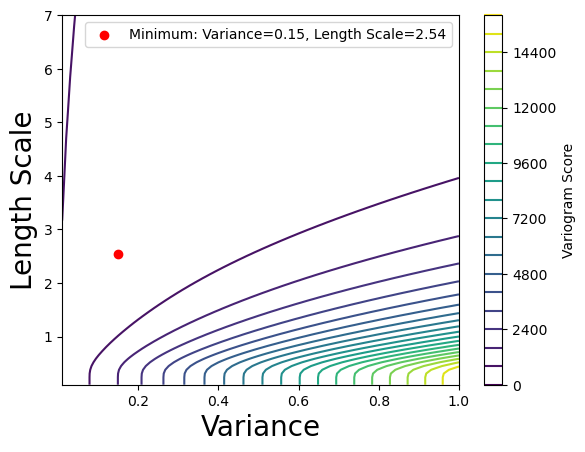

In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal
from tqdm import tqdm

def variogram(obs, sims, dist_mat, p):
    n = obs.size(0)
    m = sims.size(0)
    w_ij = torch.nan_to_num(1 / dist_mat, nan=0, posinf=0, neginf=0)
    diff_y_y = torch.abs(obs.unsqueeze(1) - obs) ** p
    diff_Y_Y = torch.abs(sims.unsqueeze(2) - sims.unsqueeze(1)).pow(p).mean(dim=0)
    SR = w_ij * (diff_y_y - diff_Y_Y) ** 2
    return SR.sum().item()

def pairwise_distance(x1, x2):
    return ((x1.unsqueeze(1) - x2.unsqueeze(0)) ** 2).sum(-1)

def RBF(variance, length_scale):
    def rbf_kernel(x1, x2):
        dist = pairwise_distance(x1, x2)
        covariance_matrix = variance * torch.exp(-0.5 * dist / length_scale ** 2)
        try:
            L = torch.cholesky(covariance_matrix, upper=False)
        except RuntimeError:
            min_eig = torch.min(torch.linalg.eigvalsh(covariance_matrix))
            covariance_matrix += torch.eye(covariance_matrix.shape[0]) * (-min_eig + 1e-6)
        return covariance_matrix
    return rbf_kernel


locs = torch.meshgrid(torch.tensor([0, 1, 2, 3, 4]), torch.tensor([0, 1, 2, 3, 4]))
locs = torch.stack((locs[0].flatten(), locs[1].flatten())).t().float()

true_length_scale = 3
true_variance = 0.2
rbf_kernel = RBF(true_variance, true_length_scale)
true_cov = rbf_kernel(locs, locs)
mvn = MultivariateNormal(torch.zeros(locs.size(0)), covariance_matrix=true_cov.float())
obs_z = mvn.sample((100,))

# Define the range of length scales and variances
length_scales = torch.linspace(0.1, 7, 100)
variances = torch.linspace(0.01, 1, 100)

SR_V = torch.zeros((len(length_scales), len(variances)))

for i, length_scale in enumerate(length_scales):
    for j, variance in enumerate(variances):
        vario_ = 0
        cov_ = RBF(variance, length_scale)(locs, locs)
        torch.manual_seed(42)
        for k in range(len(obs_z)):
            multi = MultivariateNormal(torch.zeros(25), covariance_matrix=cov_.float())
            sims = multi.sample((100,))
            vario_ = torch.tensor(vario_) + variogram(obs_z[k], sims, pairwise_distance(locs, locs), 1)
        SR_V[i, j] = vario_.item()

# Contour plot
plt.contour(variances, length_scales, SR_V, levels=20)
plt.colorbar(label='Variogram Score')
plt.title("")
plt.xlabel('Variance', fontsize=20)
plt.ylabel('Length Scale', fontsize=20)
# Highlight minimum value
min_value = SR_V.min()
min_indices = np.unravel_index(torch.argmin(SR_V).item(), SR_V.shape)
min_var, min_ls = variances[min_indices[1]].item(), length_scales[min_indices[0]].item()
plt.scatter(min_var, min_ls, color='red', label=f'Minimum: Variance={min_var:.2f}, Length Scale={min_ls:.2f}')
plt.legend()

plt.show()


C:\Users\rikhi\AppData\Local\Temp\ipykernel_16024\42780759.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vario_ = torch.tensor(vario_) + variogram(obs_z[k], sims, pairwise_distance(locs, locs), 1)


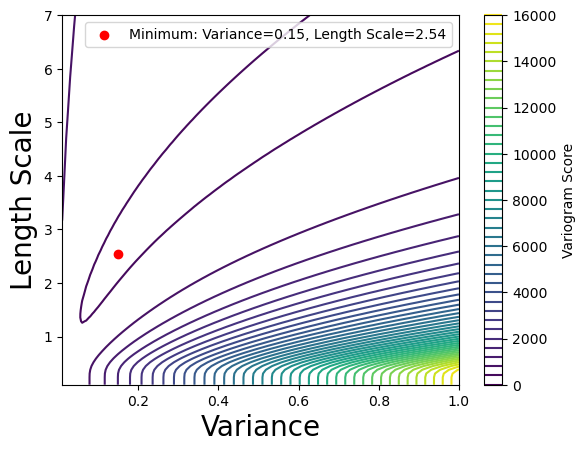

In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal
from tqdm import tqdm

def variogram(obs, sims, dist_mat, p):
    n = obs.size(0)
    m = sims.size(0)
    w_ij = torch.nan_to_num(1 / dist_mat, nan=0, posinf=0, neginf=0)
    diff_y_y = torch.abs(obs.unsqueeze(1) - obs) ** p
    diff_Y_Y = torch.abs(sims.unsqueeze(2) - sims.unsqueeze(1)).pow(p).mean(dim=0)
    SR = w_ij * (diff_y_y - diff_Y_Y) ** 2
    return SR.sum().item()

def pairwise_distance(x1, x2):
    return ((x1.unsqueeze(1) - x2.unsqueeze(0)) ** 2).sum(-1)

def RBF(variance, length_scale):
    def rbf_kernel(x1, x2):
        dist = pairwise_distance(x1, x2)
        covariance_matrix = variance * torch.exp(-0.5 * dist / length_scale ** 2)
        try:
            L = torch.cholesky(covariance_matrix, upper=False)
        except RuntimeError:
            min_eig = torch.min(torch.linalg.eigvalsh(covariance_matrix))
            covariance_matrix += torch.eye(covariance_matrix.shape[0]) * (-min_eig + 1e-6)
        return covariance_matrix
    return rbf_kernel


locs = torch.meshgrid(torch.tensor([0, 1, 2, 3, 4]), torch.tensor([0, 1, 2, 3, 4]))
locs = torch.stack((locs[0].flatten(), locs[1].flatten())).t().float()

true_length_scale = 3
true_variance = 0.2
rbf_kernel = RBF(true_variance, true_length_scale)
true_cov = rbf_kernel(locs, locs)
mvn = MultivariateNormal(torch.zeros(locs.size(0)), covariance_matrix=true_cov.float())
obs_z = mvn.sample((100,))

# Define the range of length scales and variances
length_scales = torch.linspace(0.1, 7, 100)
variances = torch.linspace(0.01, 1, 100)

SR_V = torch.zeros((len(length_scales), len(variances)))

for i, length_scale in enumerate(length_scales):
    for j, variance in enumerate(variances):
        vario_ = 0
        cov_ = RBF(variance, length_scale)(locs, locs)
        torch.manual_seed(42)
        for k in range(len(obs_z)):
            multi = MultivariateNormal(torch.zeros(25), covariance_matrix=cov_.float())
            sims = multi.sample((100,))
            vario_ = torch.tensor(vario_) + variogram(obs_z[k], sims, pairwise_distance(locs, locs), 1)
        SR_V[i, j] = vario_.item()

# Contour plot
plt.contour(variances, length_scales, SR_V, levels=40)
plt.colorbar(label='Variogram Score')
plt.title("")
plt.xlabel('Variance', fontsize=20)
plt.ylabel('Length Scale', fontsize=20)
# Highlight minimum value
min_value = SR_V.min()
min_indices = np.unravel_index(torch.argmin(SR_V).item(), SR_V.shape)
min_var, min_ls = variances[min_indices[1]].item(), length_scales[min_indices[0]].item()
plt.scatter(min_var, min_ls, color='red', label=f'Minimum: Variance={min_var:.2f}, Length Scale={min_ls:.2f}')
plt.legend()

plt.show()


# True Parameters (0.1, 2)

## Variance

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\rikhi\AppData\Local\Temp\ipykernel_28516\2403905536.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vario_ = torch.tensor(vario_) + variogram(obs_z[k], sims, dist_mat, 1)
100%|██████████| 100/100 [00:30<00:00,  3.29it/s]


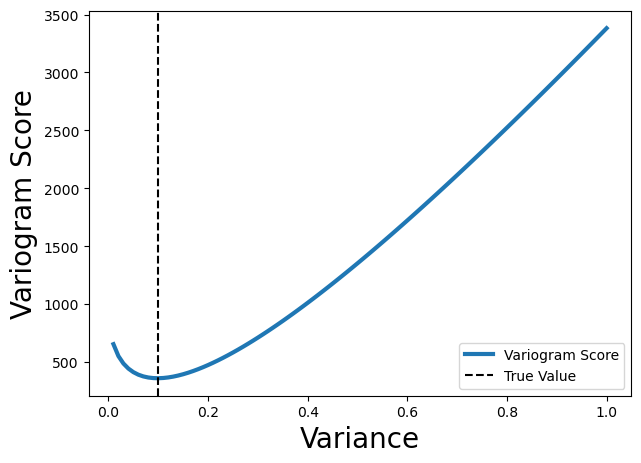

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal
from tqdm import tqdm

def variogram(obs, sims, dist_mat, p):
    '''
    Variogram score from eq 10 in Pacchiardi paper [2024 Probabilistic Forecasting with Generative Networks
    via Scoring Rule Minimization] in JMLR.

    SR = sum_ij w_ij * (|y_i - y_j|^p - |Y_k,i - Y_k,j|^p)^2
    '''
    n = obs.size(0)
    m = sims.size(0)
    w_ij = torch.nan_to_num(1 / dist_mat, nan=0, posinf=0, neginf=0)
    diff_y_y = torch.abs(obs.unsqueeze(1) - obs) ** p
    diff_Y_Y = torch.abs(sims.unsqueeze(2) - sims.unsqueeze(1)).pow(p).mean(dim=0)

    SR = w_ij * (diff_y_y - diff_Y_Y) ** 2
    return SR.sum().item()

def pairwise_distance(x1, x2):
    return ((x1.unsqueeze(1) - x2.unsqueeze(0)) ** 2).sum(-1)

def RBF(variance, length_scale):
    def rbf_kernel(x1, x2):
        dist = pairwise_distance(x1, x2)
        covariance_matrix = variance*torch.exp(-0.5 * dist / length_scale ** 2)
        # Ensure positive definiteness using Cholesky decomposition
        try:
            L = torch.cholesky(covariance_matrix, upper=False)
        except RuntimeError:
            min_eig = torch.min(torch.linalg.eigvalsh(covariance_matrix))
            covariance_matrix += torch.eye(covariance_matrix.shape[0]) * (-min_eig + 1e-6)
        
        return covariance_matrix
    return rbf_kernel


locs = torch.meshgrid(torch.tensor([0,1,2,3,4]), torch.tensor([0,1,2,3,4]))
locs = torch.stack((locs[0].flatten(), locs[1].flatten())).t().float()

# Define the RBF kernel using the RBF function
length_scale = 2
variance = 0.1
rbf_kernel = RBF(variance, length_scale)

# Compute the true covariance matrix
true_cov = rbf_kernel(locs, locs)

mvn = MultivariateNormal(torch.zeros(25), covariance_matrix=true_cov.float())
obs_z = mvn.sample((100,))

# Variogram
SR_V = []
mean = torch.zeros(25)
for i in tqdm(torch.linspace(0.01, 1, 100)):
    torch.manual_seed(42) 
    cov_ = RBF(i, length_scale)(locs, locs)
    vario_ = 0
    for k in range(len(obs_z)):
        multi = MultivariateNormal(torch.zeros(25), covariance_matrix=cov_.float())
        sims = multi.sample((100,))
        vario_ = torch.tensor(vario_) + variogram(obs_z[k], sims, dist_mat, 1)
    SR_V.append(vario_.item())


plt.figure(figsize=(7, 5))
plt.plot(torch.linspace(0.01, 1, 100), SR_V , label='Variogram Score', linewidth=3)
plt.axvline(x=0.1, color='black', linestyle='--', label='True Value')
plt.legend()


plt.xlabel('Variance', fontsize=20)
plt.ylabel('Variogram Score', fontsize=20)


plt.show()



## Length Scale

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\rikhi\AppData\Local\Temp\ipykernel_28516\2838555250.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vario_ = torch.tensor(vario_) + variogram(obs_z[k], sims, dist_mat, 1)
100%|██████████| 100/100 [00:27<00:00,  3.66it/s]


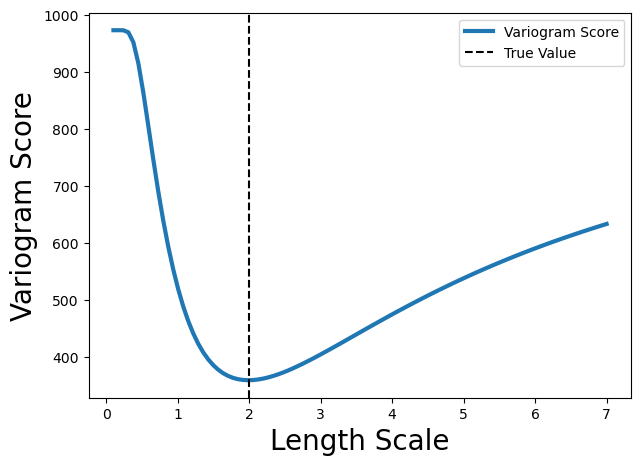

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal
from tqdm import tqdm

def variogram(obs, sims, dist_mat, p):
    '''
    Variogram score from eq 10 in Pacchiardi paper [2024 Probabilistic Forecasting with Generative Networks
    via Scoring Rule Minimization] in JMLR.

    SR = sum_ij w_ij * (|y_i - y_j|^p - |Y_k,i - Y_k,j|^p)^2
    '''
    n = obs.size(0)
    m = sims.size(0)
    w_ij = torch.nan_to_num(1 / dist_mat, nan=0, posinf=0, neginf=0)
    diff_y_y = torch.abs(obs.unsqueeze(1) - obs) ** p
    diff_Y_Y = torch.abs(sims.unsqueeze(2) - sims.unsqueeze(1)).pow(p).mean(dim=0)

    SR = w_ij * (diff_y_y - diff_Y_Y) ** 2
    return SR.sum().item()

def pairwise_distance(x1, x2):
    return ((x1.unsqueeze(1) - x2.unsqueeze(0)) ** 2).sum(-1)

def RBF(variance, length_scale):
    def rbf_kernel(x1, x2):
        dist = pairwise_distance(x1, x2)
        covariance_matrix = variance*torch.exp(-0.5 * dist / length_scale ** 2)
        # Ensure positive definiteness using Cholesky decomposition
        try:
            L = torch.cholesky(covariance_matrix, upper=False)
        except RuntimeError:
            min_eig = torch.min(torch.linalg.eigvalsh(covariance_matrix))
            covariance_matrix += torch.eye(covariance_matrix.shape[0]) * (-min_eig + 1e-6)
        
        return covariance_matrix
    return rbf_kernel


locs = torch.meshgrid(torch.tensor([0,1,2,3,4]), torch.tensor([0,1,2,3,4]))
locs = torch.stack((locs[0].flatten(), locs[1].flatten())).t().float()
dist_mat = pairwise_distance(locs, locs)
dist_mat += 1e-9


# Define the RBF kernel
length_scale = 2
variance = 0.1
rbf_kernel = RBF(variance, length_scale)

# Compute the true covariance matrix
true_cov = rbf_kernel(locs, locs)

mvn = MultivariateNormal(torch.zeros(25), covariance_matrix=true_cov.float())
obs_z = mvn.sample((100,))

# Variogram
SR_V = []
mean = torch.zeros(25)
for i in tqdm(torch.linspace(0.1, 7, 100)):
    torch.manual_seed(42)  
    cov_ = RBF(variance, i)(locs, locs)
    vario_ = 0
    for k in range(len(obs_z)):
        multi = MultivariateNormal(torch.zeros(25), covariance_matrix=cov_.float())
        sims = multi.sample((100,))
        vario_ = torch.tensor(vario_) + variogram(obs_z[k], sims, dist_mat, 1)
    SR_V.append(vario_.item())

plt.figure(figsize=(7, 5))
plt.plot(torch.linspace(0.1, 7, 100), SR_V , label='Variogram Score', linewidth=3)
plt.axvline(x=2, color='black', linestyle='--', label='True Value')
plt.legend()


plt.xlabel('Length Scale', fontsize=20)
plt.ylabel('Variogram Score', fontsize=20)


plt.show()



## Bivariate Contour Plot

C:\Users\rikhi\AppData\Local\Temp\ipykernel_16024\712540562.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vario_ = torch.tensor(vario_) + variogram(obs_z[k], sims, pairwise_distance(locs, locs), 1)


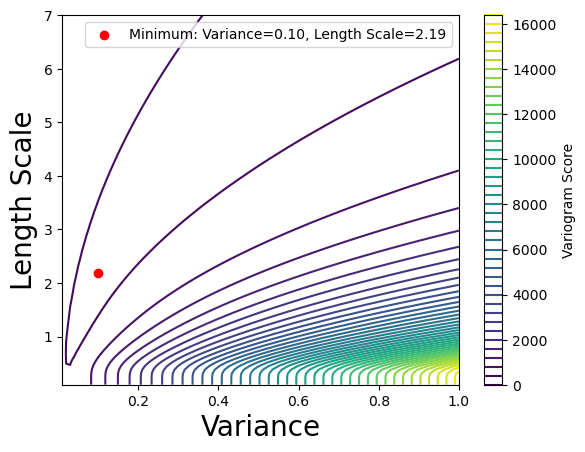

In [26]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal
from tqdm import tqdm

def variogram(obs, sims, dist_mat, p):
    n = obs.size(0)
    m = sims.size(0)
    w_ij = torch.nan_to_num(1 / dist_mat, nan=0, posinf=0, neginf=0)
    diff_y_y = torch.abs(obs.unsqueeze(1) - obs) ** p
    diff_Y_Y = torch.abs(sims.unsqueeze(2) - sims.unsqueeze(1)).pow(p).mean(dim=0)
    SR = w_ij * (diff_y_y - diff_Y_Y) ** 2
    return SR.sum().item()

def pairwise_distance(x1, x2):
    return ((x1.unsqueeze(1) - x2.unsqueeze(0)) ** 2).sum(-1)

def RBF(variance, length_scale):
    def rbf_kernel(x1, x2):
        dist = pairwise_distance(x1, x2)
        covariance_matrix = variance * torch.exp(-0.5 * dist / length_scale ** 2)
        try:
            L = torch.cholesky(covariance_matrix, upper=False)
        except RuntimeError:
            min_eig = torch.min(torch.linalg.eigvalsh(covariance_matrix))
            covariance_matrix += torch.eye(covariance_matrix.shape[0]) * (-min_eig + 1e-6)
        return covariance_matrix
    return rbf_kernel


locs = torch.meshgrid(torch.tensor([0, 1, 2, 3, 4]), torch.tensor([0, 1, 2, 3, 4]))
locs = torch.stack((locs[0].flatten(), locs[1].flatten())).t().float()

true_length_scale = 2
true_variance = 0.1
rbf_kernel = RBF(true_variance, true_length_scale)
true_cov = rbf_kernel(locs, locs)
mvn = MultivariateNormal(torch.zeros(locs.size(0)), covariance_matrix=true_cov.float())
obs_z = mvn.sample((100,))

# Define the range of length scales and variances
length_scales = torch.linspace(0.1, 7, 100)
variances = torch.linspace(0.01, 1, 100)

SR_V = torch.zeros((len(length_scales), len(variances)))

for i, length_scale in enumerate(length_scales):
    for j, variance in enumerate(variances):
        vario_ = 0
        cov_ = RBF(variance, length_scale)(locs, locs)
        torch.manual_seed(42)
        for k in range(len(obs_z)):
            multi = MultivariateNormal(torch.zeros(25), covariance_matrix=cov_.float())
            sims = multi.sample((100,))
            vario_ = torch.tensor(vario_) + variogram(obs_z[k], sims, pairwise_distance(locs, locs), 1)
        SR_V[i, j] = vario_.item()

# Contour plot
plt.contour(variances, length_scales, SR_V, levels=40)
plt.colorbar(label='Variogram Score')
plt.title("")
plt.xlabel('Variance', fontsize=20)
plt.ylabel('Length Scale', fontsize=20)
# Highlight minimum value
min_value = SR_V.min()
min_indices = np.unravel_index(torch.argmin(SR_V).item(), SR_V.shape)
min_var, min_ls = variances[min_indices[1]].item(), length_scales[min_indices[0]].item()
plt.scatter(min_var, min_ls, color='red', label=f'Minimum: Variance={min_var:.2f}, Length Scale={min_ls:.2f}')
plt.legend()

plt.show()


# True Parameters (0.6, 5)

## Variance

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\rikhi\AppData\Local\Temp\ipykernel_28516\2387125675.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vario_ = torch.tensor(vario_) + variogram(obs_z[k], sims, dist_mat, 1)
100%|██████████| 100/100 [00:26<00:00,  3.79it/s]


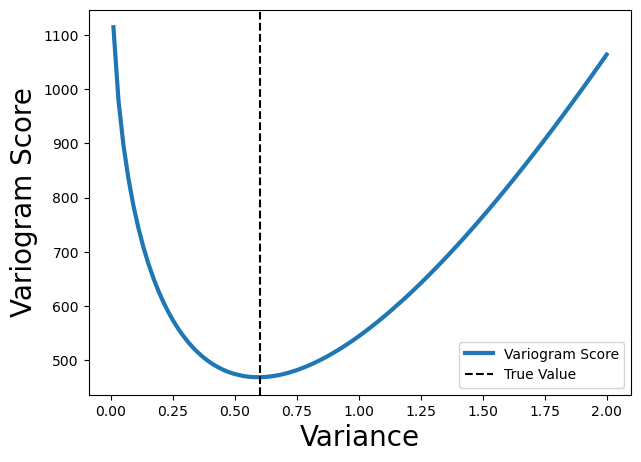

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal
from tqdm import tqdm

def variogram(obs, sims, dist_mat, p):
    '''
    Variogram score from eq 10 in Pacchiardi paper [2024 Probabilistic Forecasting with Generative Networks
    via Scoring Rule Minimization] in JMLR.

    SR = sum_ij w_ij * (|y_i - y_j|^p - |Y_k,i - Y_k,j|^p)^2
    '''
    n = obs.size(0)
    m = sims.size(0)
    w_ij = torch.nan_to_num(1 / dist_mat, nan=0, posinf=0, neginf=0)
    diff_y_y = torch.abs(obs.unsqueeze(1) - obs) ** p
    diff_Y_Y = torch.abs(sims.unsqueeze(2) - sims.unsqueeze(1)).pow(p).mean(dim=0)

    SR = w_ij * (diff_y_y - diff_Y_Y) ** 2
    return SR.sum().item()

def pairwise_distance(x1, x2):
    return ((x1.unsqueeze(1) - x2.unsqueeze(0)) ** 2).sum(-1)

def RBF(variance, length_scale):
    def rbf_kernel(x1, x2):
        dist = pairwise_distance(x1, x2)
        covariance_matrix = variance*torch.exp(-0.5 * dist / length_scale ** 2)
        # Ensure positive definiteness using Cholesky decomposition
        try:
            L = torch.cholesky(covariance_matrix, upper=False)
        except RuntimeError:
            min_eig = torch.min(torch.linalg.eigvalsh(covariance_matrix))
            covariance_matrix += torch.eye(covariance_matrix.shape[0]) * (-min_eig + 1e-6)
        
        return covariance_matrix
    return rbf_kernel


locs = torch.meshgrid(torch.tensor([0,1,2,3,4]), torch.tensor([0,1,2,3,4]))
locs = torch.stack((locs[0].flatten(), locs[1].flatten())).t().float()

# Define the RBF kernel
length_scale = 5
variance = 0.6
rbf_kernel = RBF(variance, length_scale)

# Compute the true covariance matrix
true_cov = rbf_kernel(locs, locs)

mvn = MultivariateNormal(torch.zeros(25), covariance_matrix=true_cov.float())
obs_z = mvn.sample((100,))

# Variogram
SR_V = []
mean = torch.zeros(25)
for i in tqdm(torch.linspace(0.01, 2, 100)):
    torch.manual_seed(42)  
    cov_ = RBF(i, length_scale)(locs, locs)
    vario_ = 0
    for k in range(len(obs_z)):
        multi = MultivariateNormal(torch.zeros(25), covariance_matrix=cov_.float())
        sims = multi.sample((100,))
        vario_ = torch.tensor(vario_) + variogram(obs_z[k], sims, dist_mat, 1)
    SR_V.append(vario_.item())


plt.figure(figsize=(7, 5))
plt.plot(torch.linspace(0.01, 2, 100), SR_V , label='Variogram Score', linewidth=3)
plt.axvline(x=0.6, color='black', linestyle='--', label='True Value')
plt.legend()


plt.xlabel('Variance', fontsize=20)
plt.ylabel('Variogram Score', fontsize=20)


plt.show()



## Length Scale

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\rikhi\AppData\Local\Temp\ipykernel_28516\3517472336.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vario_ = torch.tensor(vario_) + variogram(obs_z[k], sims, dist_mat, 1)
100%|██████████| 100/100 [00:31<00:00,  3.13it/s]


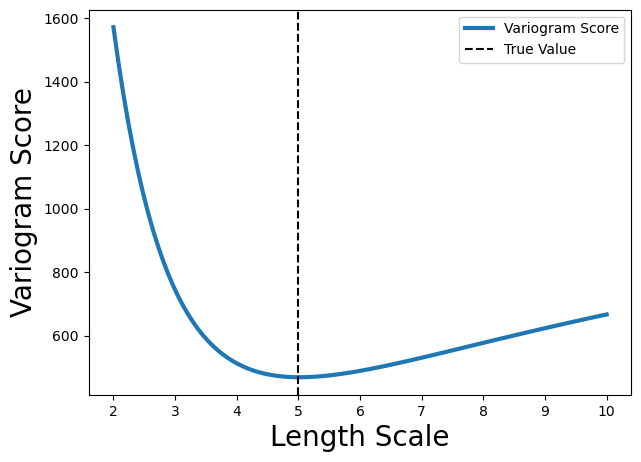

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal
from tqdm import tqdm

def variogram(obs, sims, dist_mat, p):
    '''
    Variogram score from eq 10 in Pacchiardi paper [2024 Probabilistic Forecasting with Generative Networks
    via Scoring Rule Minimization] in JMLR.

    SR = sum_ij w_ij * (|y_i - y_j|^p - |Y_k,i - Y_k,j|^p)^2
    '''
    n = obs.size(0)
    m = sims.size(0)
    w_ij = torch.nan_to_num(1 / dist_mat, nan=0, posinf=0, neginf=0)
    diff_y_y = torch.abs(obs.unsqueeze(1) - obs) ** p
    diff_Y_Y = torch.abs(sims.unsqueeze(2) - sims.unsqueeze(1)).pow(p).mean(dim=0)

    SR = w_ij * (diff_y_y - diff_Y_Y) ** 2
    return SR.sum().item()

def pairwise_distance(x1, x2):
    return ((x1.unsqueeze(1) - x2.unsqueeze(0)) ** 2).sum(-1)

def RBF(variance, length_scale):
    def rbf_kernel(x1, x2):
        dist = pairwise_distance(x1, x2)
        covariance_matrix = variance*torch.exp(-0.5 * dist / length_scale ** 2)
        # Ensure positive definiteness using Cholesky decomposition
        try:
            L = torch.cholesky(covariance_matrix, upper=False)
        except RuntimeError:
            min_eig = torch.min(torch.linalg.eigvalsh(covariance_matrix))
            covariance_matrix += torch.eye(covariance_matrix.shape[0]) * (-min_eig + 1e-6)
        
        return covariance_matrix
    return rbf_kernel


locs = torch.meshgrid(torch.tensor([0,1,2,3,4]), torch.tensor([0,1,2,3,4]))
locs = torch.stack((locs[0].flatten(), locs[1].flatten())).t().float()
dist_mat = pairwise_distance(locs, locs)
dist_mat += 1e-9


# Define the RBF kernel
length_scale = 5
variance = 0.6
rbf_kernel = RBF(variance, length_scale)

# Compute the true covariance matrix
true_cov = rbf_kernel(locs, locs)

mvn = MultivariateNormal(torch.zeros(25), covariance_matrix=true_cov.float())
obs_z = mvn.sample((100,))

# Variogram
SR_V = []
mean = torch.zeros(25)
for i in tqdm(torch.linspace(2, 10, 100)):
    torch.manual_seed(42) 
    cov_ = RBF(variance, i)(locs, locs)
    vario_ = 0
    for k in range(len(obs_z)):
        multi = MultivariateNormal(torch.zeros(25), covariance_matrix=cov_.float())
        sims = multi.sample((100,))
        vario_ = torch.tensor(vario_) + variogram(obs_z[k], sims, dist_mat, 1)
    SR_V.append(vario_.item())

plt.figure(figsize=(7, 5))
plt.plot(torch.linspace(2, 10, 100), SR_V , label='Variogram Score', linewidth=3)
plt.axvline(x=5, color='black', linestyle='--', label='True Value')
plt.legend()


plt.xlabel('Length Scale', fontsize=20)
plt.ylabel('Variogram Score', fontsize=20)


plt.show()



## Bivariate Contour Plot

C:\Users\rikhi\AppData\Local\Temp\ipykernel_28516\822575812.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vario_ = torch.tensor(vario_) + variogram(obs_z[k], sims, pairwise_distance(locs, locs), 1)


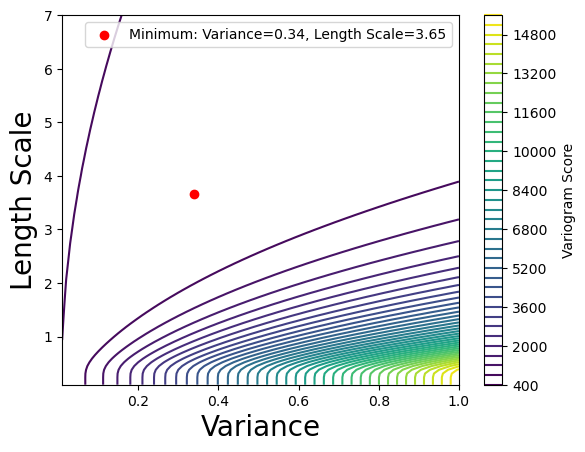

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal
from tqdm import tqdm

def variogram(obs, sims, dist_mat, p):
    n = obs.size(0)
    m = sims.size(0)
    w_ij = torch.nan_to_num(1 / dist_mat, nan=0, posinf=0, neginf=0)
    diff_y_y = torch.abs(obs.unsqueeze(1) - obs) ** p
    diff_Y_Y = torch.abs(sims.unsqueeze(2) - sims.unsqueeze(1)).pow(p).mean(dim=0)
    SR = w_ij * (diff_y_y - diff_Y_Y) ** 2
    return SR.sum().item()

def pairwise_distance(x1, x2):
    return ((x1.unsqueeze(1) - x2.unsqueeze(0)) ** 2).sum(-1)

def RBF(variance, length_scale):
    def rbf_kernel(x1, x2):
        dist = pairwise_distance(x1, x2)
        covariance_matrix = variance * torch.exp(-0.5 * dist / length_scale ** 2)
        try:
            L = torch.cholesky(covariance_matrix, upper=False)
        except RuntimeError:
            min_eig = torch.min(torch.linalg.eigvalsh(covariance_matrix))
            covariance_matrix += torch.eye(covariance_matrix.shape[0]) * (-min_eig + 1e-6)
        return covariance_matrix
    return rbf_kernel


locs = torch.meshgrid(torch.tensor([0, 1, 2, 3, 4]), torch.tensor([0, 1, 2, 3, 4]))
locs = torch.stack((locs[0].flatten(), locs[1].flatten())).t().float()

true_length_scale = 5
true_variance = 0.6
rbf_kernel = RBF(true_variance, true_length_scale)
true_cov = rbf_kernel(locs, locs)
mvn = MultivariateNormal(torch.zeros(locs.size(0)), covariance_matrix=true_cov.float())
obs_z = mvn.sample((100,))

# Define the range of length scales and variances
length_scales = torch.linspace(0.1, 7, 100)
variances = torch.linspace(0.01, 1, 100)

SR_V = torch.zeros((len(length_scales), len(variances)))

for i, length_scale in enumerate(length_scales):
    for j, variance in enumerate(variances):
        vario_ = 0
        cov_ = RBF(variance, length_scale)(locs, locs)
        torch.manual_seed(42)
        for k in range(len(obs_z)):
            multi = MultivariateNormal(torch.zeros(25), covariance_matrix=cov_.float())
            sims = multi.sample((100,))
            vario_ = torch.tensor(vario_) + variogram(obs_z[k], sims, pairwise_distance(locs, locs), 1)
        SR_V[i, j] = vario_.item()

# Contour plot
plt.contour(variances, length_scales, SR_V, levels=40)
plt.colorbar(label='Variogram Score')
plt.title("")
plt.xlabel('Variance', fontsize=20)
plt.ylabel('Length Scale', fontsize=20)
# Highlight minimum value
min_value = SR_V.min()
min_indices = np.unravel_index(torch.argmin(SR_V).item(), SR_V.shape)
min_var, min_ls = variances[min_indices[1]].item(), length_scales[min_indices[0]].item()
plt.scatter(min_var, min_ls, color='red', label=f'Minimum: Variance={min_var:.2f}, Length Scale={min_ls:.2f}')
plt.legend()

plt.show()
